In [1]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import math

Welcome to JupyROOT 6.18/04


In [2]:
chain = r.TChain("farline/eventTree")
chain.Add("./9day/gm2offline_ana_233128_16528.00035.root")
chain.Add("./9day/gm2offline_ana_233130_16535.00353.root")
chain.Add("./9day/gm2offline_ana_233134_16482.00307.root")
chain.Add("./9day/gm2offline_ana_233136_16528.00161.root")

1

In [4]:
nbins = 1400
step = 20

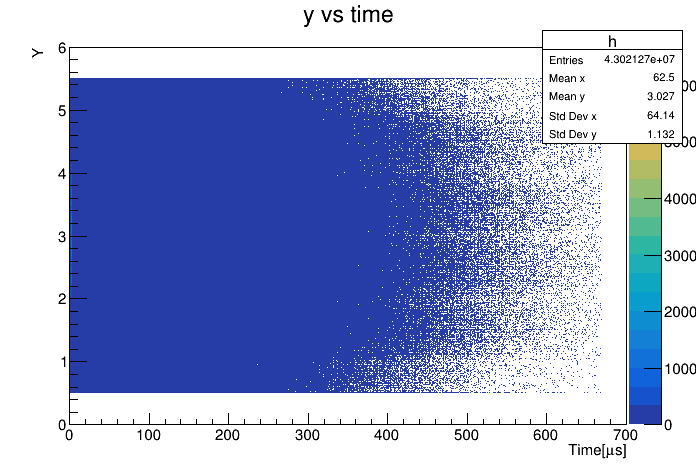

In [5]:
# Histogram containing the low energy crystal center spikes
h = r.TH2D("h", "y vs time; Time[#mus]; Y", nbins, 0,700, 600,0,6)
chain.Draw("y:time*1.25/1000.>>h", "energy<2900 && energy>1700", "goff")
c = r.TCanvas()
h.Draw("colz")
c.Draw()

In [6]:
h2 = h.Clone("h2")

In [7]:
h2.GetNbinsX()

1400

In [8]:
func = r.TF1("func", "gaus", -5, 5)


thing = h2.FitSlicesX(func, 0, 2)
print(thing)

None


FitSlicesX does not do what you want. It projects an x range to 1D then fits that. You want the distribution of stuff in an X range. ProjectionY for X bins is better.

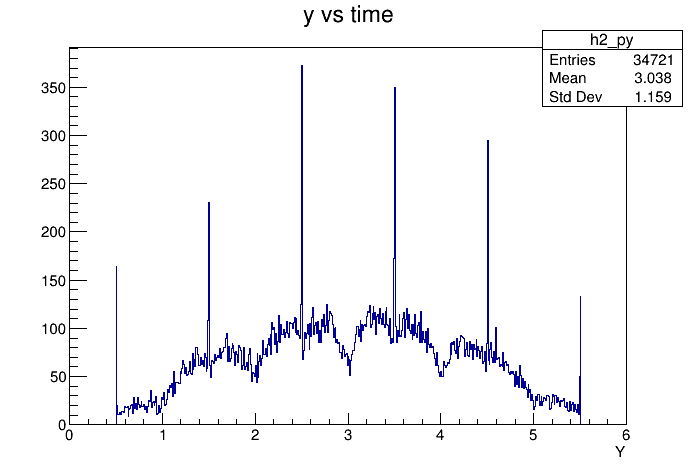

In [9]:
# just draw the projection for all bins
c = r.TCanvas()
dist = h2.ProjectionY("_py", 400, 401)
dist.Draw()
c.Draw()

In [18]:
dist.Chisquare("gaus")

TypeError: double TH1::Chisquare(TF1* f1, const char* option = "") =>
    could not convert argument 1

FitSlicesX takes a bin along x (time here), projects it to 1d, then fits that?

Wheras what we want is to take a time slice and get the distribution of y values there?

Crystal center spikes - do we want these when fitting the gaussian? These are the laser pulses?
Setting the lower energy bound of 1700 lessened these but they are still there.

What's up with the shape for just each of these crystals? The { structure.

in TF1 maybe rejectpoint to ignore the center areas that have the big spikes

big spikes are artifact of resconstruction

check if gaussian is good. Do gaussian fit with the centers and without. Do the spikes make a difference? To what parameters?


 FCN=2589.16 FROM MIGRAD    STATUS=CONVERGED      93 CALLS          94 TOTAL
                     EDM=9.70117e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.03082e+02   7.38122e-01   1.42886e-02   1.20579e-04
   2  Mean         3.06232e+00   8.60547e-03   2.13607e-04  -1.15375e-02
   3  Sigma        1.32009e+00   8.07338e-03   4.24284e-05   5.97371e-02


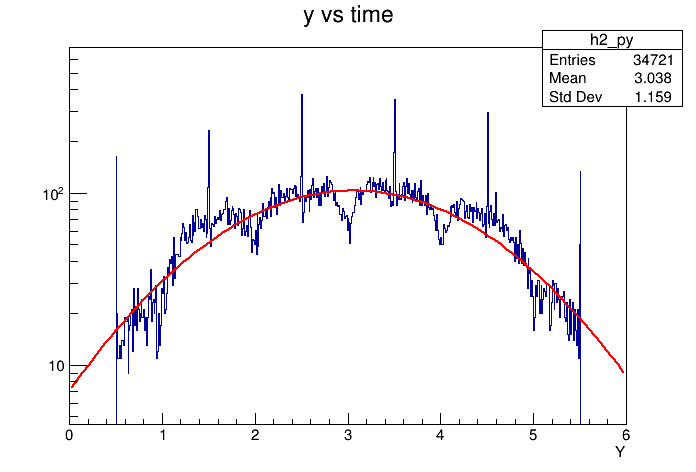

In [10]:
# do a fit on all of the bins
c = r.TCanvas()
dist.Fit("gaus","S")
c.SetLogy()
c.Draw()

Make a table of the Gaussian Mean and SD, as well as the histogram Mean and SD for each bin. Compare them, see how it goes

## Fit Result Parameter Testing!

Note that for getting paramaters from a fit result, this is the TFitResultPtr class, but it inherits some methods from the TFitResult class. Just in case you are looking for a feature but are confused by the documentation again.

In [18]:
dist.Fit("gaus", "S").Error(1)

0.008605474031218766

 FCN=2589.16 FROM MIGRAD    STATUS=CONVERGED      89 CALLS          90 TOTAL
                     EDM=9.69951e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.03082e+02   7.38122e-01   1.42886e-02   1.20593e-04
   2  Mean         3.06232e+00   8.60547e-03   2.13607e-04  -1.15344e-02
   3  Sigma        1.32009e+00   8.07338e-03   4.24284e-05   5.97421e-02


In [12]:
# list of fit values
stats = []

data = pd.DataFrame(columns=['TimeBin', 'GausConst', 'GausMean', 'GausSD', 'HistMean', 'HistSD'])

for index in range(0, h2.GetNbinsX()-step, step):
    print(index)
    h3 = h2.ProjectionY("_py", index, index+step)
    the_fit = h3.Fit("gaus", "SN")
    stats.append({
        'TimeBin':   index*(700/nbins),
        'GausConst': the_fit.Parameter(0),
        'GausMean':  the_fit.Parameter(1),
        'GausSD':    the_fit.Parameter(2),
        'HistMean':  h3.GetMean(),
        'HistSD':    h3.GetStdDev()
        })

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
 FCN=3.23558e+07 FROM MIGRAD    STATUS=CONVERGED     170 CALLS         171 TOTAL
                     EDM=2.14117e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.39918e+05   2.79746e+01   5.94614e+01   1.72461e-05
   2  Mean         2.99614e+00   2.25866e-04   6.27256e-04   2.12127e+00
   3  Sigma        1.28321e+00   2.18287e-04   1.19042e-04   1.18682e+00
 FCN=1.17307e+07 FROM MIGRAD    STATUS=CONVERGED     163 CALLS         164 TOTAL
                     EDM=1.20113e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.47642e+04   1.95211e+01   2.49575e+01 

In [13]:
for index in range(0, len(stats)):
    data.loc[index] = stats[index]

In [14]:
data

,TimeBin,GausConst,GausMean,GausSD,HistMean,HistSD
0,0.0,139918.157889,2.996137,1.283213,2.994637,1.311992
1,25.0,74764.238146,3.038818,1.468775,3.034117,1.287284
2,50.0,50977.676203,3.039002,1.469451,3.034933,1.281891
3,75.0,34386.108216,3.037539,1.472303,3.033791,1.281627
4,100.0,23202.469018,3.036295,1.473311,3.033248,1.281113
5,125.0,15837.053832,3.036378,1.472693,3.032472,1.280603
6,150.0,10775.074431,3.035279,1.473587,3.031999,1.280400
7,175.0,7261.573281,3.032771,1.475203,3.031257,1.281250
8,200.0,4917.453623,3.031660,1.473661,3.029679,1.280731
9,225.0,3362.838802,3.033487,1.474408,3.029742,1.279892


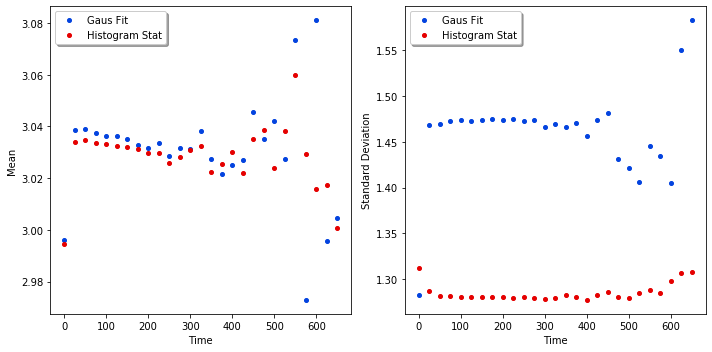

In [15]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

ax[0].plot(data['TimeBin'], data['GausMean'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
ax[0].plot(data['TimeBin'], data['HistMean'], linestyle='none', marker='o', color='xkcd:red', markersize=4, label='Histogram Stat');
ax[0].set_ylabel('Mean')
ax[0].set_xlabel('Time')
ax[0].legend(loc=0,shadow=True);

ax[1].plot(data['TimeBin'], data['GausSD'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
ax[1].plot(data['TimeBin'], data['HistSD'], linestyle='none', marker='o', color='xkcd:red', markersize=4, label='Histogram Stat');
ax[1].set_ylabel('Standard Deviation')
ax[1].set_xlabel('Time')
ax[1].legend(loc=0,shadow=True);

fig.tight_layout()

Things still to do:

-Generalize this to a function where you can set the steps and bins and just hit enter for easy comparisons

-Try getting rid of the center spikes and comparing that


In [50]:
def create_hist(t_chain, hist_name, Xbins, energy_min, energy_max, caloNum):
    """
    Creates a TH2D histogram of y vs time between 0 and 700 μs
    
    chain: [TChain] the data
    hist_name: [str] what to call the histogram
    Xbins: [int] the number of bins that should be used on the time axis
    energy_min: [int] the minimum energy threshhold
    energy_max: [int] the maximum energy threshhold
    """
    hist = r.TH2D(hist_name, "y vs time; Time[#mus]; Y", Xbins, 0,700, 600,0,6)
    t_chain.Draw("y:time*1.25/1000.>>"+hist_name,
               "energy<"+str(energy_max)+"&& energy >"+str(energy_min),
               "goff")
    
    return hist

In [51]:
hist = create_hist(chain, "h", 1400, 0, 6000, 1)

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [52]:
def reject(y, p):
    dec = y[0] % 1
    if( (dec < 0.6 and 0.4 < dec) or
        (dec < 0.02 or 0.98 < dec) or
        (y[0] < .5 or y[0] > 5.5)):
        r.TF1.RejectPoint()
        return 0
    else:
        return p[0]*math.exp(-((y[0]-p[1])**2)/(2*(p[2]**2)))

 FCN=135972 FROM MIGRAD    STATUS=CONVERGED     112 CALLS         113 TOTAL
                     EDM=4.77808e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.44067e+05   3.29112e+01  -2.76072e-01  -1.06938e-05
   2  p1           3.00012e+00   2.62364e-04   9.22106e-06   4.71645e+00
   3  p2           1.31580e+00   2.69725e-04   1.48691e-06   8.12269e-02


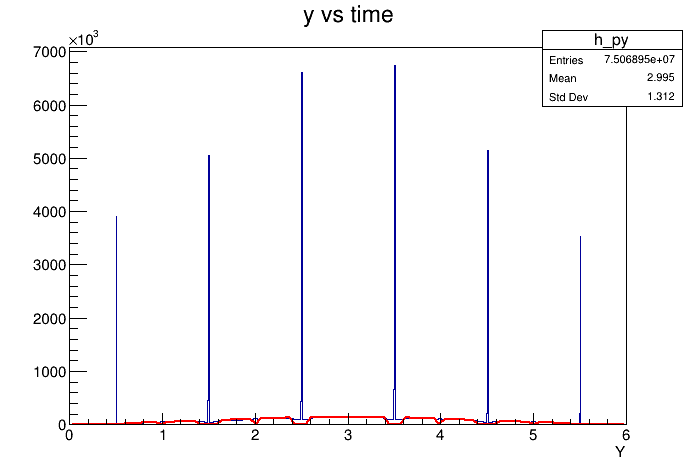

In [53]:
c = r.TCanvas()
proj = hist.ProjectionY("_py", 0, 50)
func = r.TF1("func", reject, 0, 6, 3)
func.SetParameters(1, 2, 1)
#func.Draw()
proj.Draw()
proj.Fit(func, "")
#c.SetLogy()
c.Draw()
c.Draw()


From that above thing it looks like the peaks around the integers are not very significant compared to the ones around the half integers. Adding exclusion of them caused the whole "error matrix uncertainty" deal, so I will proceed at first without removing them, removing instead only the large spikes centered at the half integer values.

In [66]:
def reject(y, p):
    dec = y[0] % 1
    if( (dec < 0.6 and 0.4 < dec) ):
        #(dec < 0.02 or 0.98 < dec) or
        #(y[0] < .5 or y[0] > 5.5)):
        r.TF1.RejectPoint()
        return 0
    else:
        return p[0]*math.exp(-((y[0]-p[1])**2)/(2*(p[2]**2)))

 FCN=166900 FROM MIGRAD    STATUS=CONVERGED     121 CALLS         122 TOTAL
                     EDM=2.59674e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.4 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.44479e+05   3.21239e+01   1.87528e-01   3.61556e-06
   2  p1           2.99926e+00   2.56182e-04  -2.08292e-06  -9.43965e-01
   3  p2           1.31973e+00   2.64484e-04  -1.52069e-06  -3.60712e-01


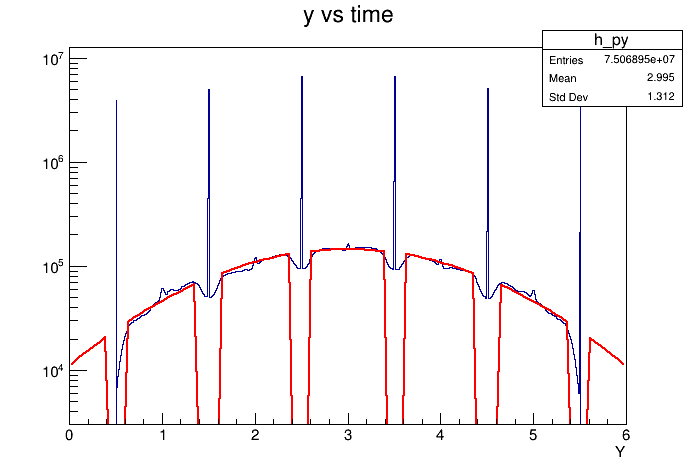

In [67]:
c = r.TCanvas()
proj = hist.ProjectionY("_py", 0, 50)
func = r.TF1("func", reject, 0, 6, 3)
func.SetParameters(1, 2, 1)
#func.Draw()
proj.Draw()
proj.Fit(func, "")
c.SetLogy()
c.Draw()
c.Draw()

This above is with 0.1 clearance on either side of a spike. The fit does not seem too happy with it though

In [82]:
def reject(y, p):
    dec = y[0] % 1
    if( (dec < (0.5 + delta) and (0.5 - delta) < dec) ):
        #(dec < 0.02 or 0.98 < dec) or
        #(y[0] < .5 or y[0] > 5.5)):
        r.TF1.RejectPoint()
        return 0
    else:
        return p[0]*math.exp(-((y[0]-p[1])**2)/(2*(p[2]**2)))

 FCN=3.22976e+07 FROM MIGRAD    STATUS=CONVERGED     127 CALLS         128 TOTAL
                     EDM=1.14478e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.39392e+05   2.84994e+01   6.05893e+01   2.77437e-05
   2  p1           2.99668e+00   2.30316e-04   6.39043e-04  -9.28127e-01
   3  p2           1.27968e+00   2.21744e-04   4.71388e-04   8.45413e+00
 FCN=921810 FROM MIGRAD    STATUS=CONVERGED     116 CALLS         117 TOTAL
                     EDM=6.50076e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.37003e+05   2.85214e+01   1.03016e-02   1.11998e-06
   2  p1           2.99559e+00   2.34678e-04   7.44880e-07   1.17279e-02
   3  p2         

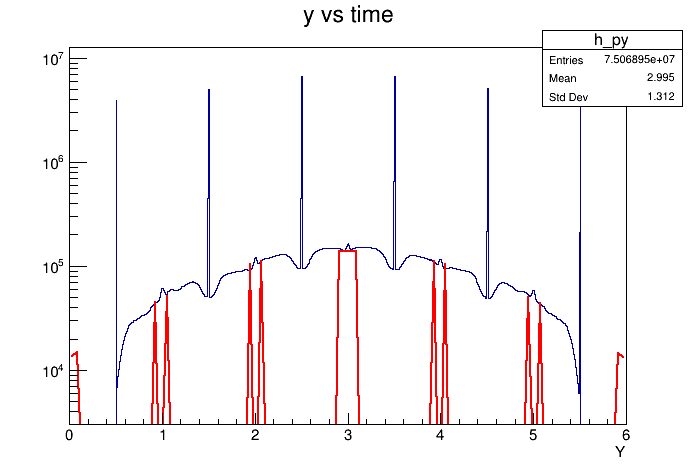

In [99]:
for i in range(0, 40):
    delta = i / 100
    
    def reject(y, p):
        dec = y[0] % 1
        if( (dec < (0.5 + delta) and (0.5 - delta) < dec) or
            (dec < 0.02 or 0.98 < dec) ):
            #(y[0] < .5 or y[0] > 5.5)):
            r.TF1.RejectPoint()
            return 0
        else:
            return p[0]*math.exp(-((y[0]-p[1])**2)/(2*(p[2]**2)))

    c = r.TCanvas()
    proj = hist.ProjectionY("_py", 0, 50)
    func = r.TF1("func", reject, 0, 6, 3)
    func.SetParameters(1, 2, 1)
    #func.Draw()
    proj.Draw()
    fit = proj.Fit(func, "")
    c.SetLogy()
    c.Draw()
    c.Draw()

i = 28 was successful, so a δ of 0.28 from the center of the spike should be good for fitting I guess, but it's kinda large and leaves out a ton of data. Also just below you can see it does not work that well:

In [112]:
def reject(y, p):
    dec = y[0] % 1
    if( (dec < (0.5 + 0.28) and (0.5 - 0.28) < dec) ):
        #(dec < 0.02 or 0.98 < dec) or
        #(y[0] < .5 or y[0] > 5.5)):
        r.TF1.RejectPoint()
        return 0
    else:
        return p[0]*math.exp(-((y[0]-p[1])**2)/(2*(p[2]**2)))

 FCN=90048 FROM MIGRAD    STATUS=CONVERGED     126 CALLS         127 TOTAL
                     EDM=6.48304e-11    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.44662e+05   4.37709e+01  -8.22789e-02  -2.47618e-07
   2  p1           2.99653e+00   3.50927e-04  -2.48171e-08   3.48546e-02
   3  p2           1.33710e+00   3.75927e-04   7.38415e-08  -5.09709e-03


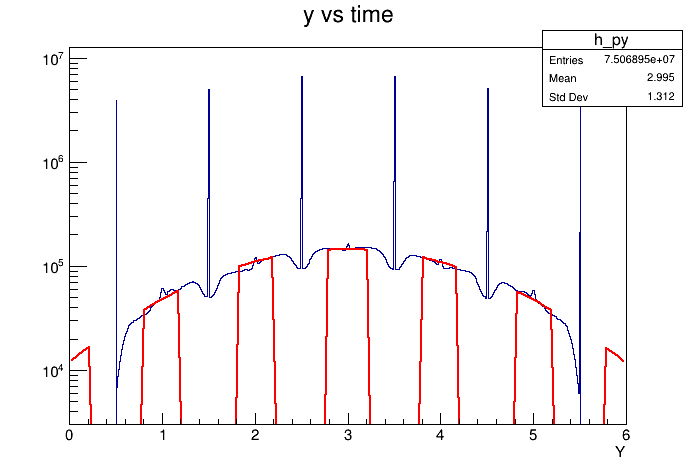

In [113]:
c = r.TCanvas()
proj = hist.ProjectionY("_py", 0, 50)
func = r.TF1("func", reject, 0, 6, 3)
func.SetParameters(1, 2, 1)
#func.Draw()
proj.Draw()
proj.Fit(func, "")
c.SetLogy()
c.Draw()
c.Draw()


In [23]:

for num in range(0, 4):
    print(str(6*num + 1) + '-' + str(6*num + 6))

1-6
7-12
13-18
19-24


In [22]:
for i in range(1, 24, 6):
    memes = []
    for num in range(i, i+6):
        memes.append(num)
    print(memes)

[1, 2, 3, 4, 5, 6]
[7, 8, 9, 10, 11, 12]
[13, 14, 15, 16, 17, 18]
[19, 20, 21, 22, 23, 24]
